## 使用DenseNet做模型訓練

本練習使用CIFAR10資料集：https://www.cs.toronto.edu/~kriz/cifar.html

---

In [1]:
# =========================================================================
# 由於課堂上可能有多人共用同一顆GPU，以下限定使用者只能用計算卡上45%的記憶體。
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45 # 使用45%記憶體
set_session(tf.Session(config=config))
# =========================================================================

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.metrics import classification_report
import json
import pickle

import cv2

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint

from densenet import MY_DenseNet

## <a id='01'>載入圖片至電腦記憶體 </a>

首先看一下包含資料集的資料夾有什麼內容：

In [3]:
! ls -hl ../datasets/cifar-10-batches-py/

total 178M
-rw-r--r-- 1 1000 1000 158 Sep 29 01:13 batches.meta
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_1
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_2
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_3
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_4
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 data_batch_5
-rw-r--r-- 1 1000 1000  60 Sep 29 01:13 labels.txt
-rw-r--r-- 1 1000 1000  88 Sep 29 01:13 readme.html
-rw-r--r-- 1 1000 1000 30M Sep 29 01:13 test_batch


data_batch_1, data_batch_2,..data_batch_5以及test_batch是以binary的方式儲存在硬碟裡。以下我們寫幾個函數，用以載入這些binary格式的圖檔至電腦內的記憶體中，並且將圖的以矩陣的方式儲存。這些圖矩陣的shape為(Number of figures,Width,Height,Channel)。

In [4]:
def load_batch(fpath):
    """This function extract a batch of CIFAR10 data
       from the chosen binary file.
       This function is a simplified version of
       https://github.com/keras-team/keras/blob/master/keras/datasets/cifar.py
    """
    with open(fpath, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        # Keys are in the "byte" format. Let's decode them into utf8 strings.
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    data = d['data']
    labels = d['labels']
    data = data.reshape(data.shape[0], 3, 32, 32)
    data = data.transpose(0,2,3,1)
    return data,labels

def load_data(path):
    '''
    載入以binary方式儲存的影像至電腦內記憶體。
    '''
    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 32,32,3), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_') + str(i)
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000:i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000:i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    return (x_train, y_train), (np.array(x_test), np.array(y_test,dtype="uint8"))

In [5]:
(x_train, y_train), (x_test, y_test)=load_data('../datasets/cifar-10-batches-py')

In [6]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


以上，我們得到了x_train, x_test, y_train,y_test四個放置圖片的矩陣，其shape均為(Number of figures,Width,Height,Channel)。

接著，我們抽出幾張圖來看，稍微了解一下這些資料大概的樣貌：

In [7]:
with open("../datasets/cifar-10-batches-py/labels.txt") as reader:
    fig_labels=reader.read()
fig_labels=fig_labels.split("\n")[:-1]

In [8]:
idx_to_label={}
for idx,fig_labels in enumerate(fig_labels):
        idx_to_label[idx]=fig_labels

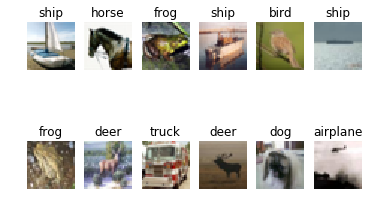

In [9]:
#隨機抽取12張圖來看一下
num_figures_display=12
fig_indexes=np.random.choice(x_train.shape[0],num_figures_display)

fig,axes=plt.subplots(2,6)
for fig_idx,axis in zip(fig_indexes,axes.reshape(-1) ):
    axis.axis('off')
    axis.imshow(x_train[fig_idx])
    axis.set_title(idx_to_label[ y_train[fig_idx] ])

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='02'> 將圖片做一些預處理 </a>

In [10]:
# 做normalization
data_type=np.float32
n_channels=3
for i in range(n_channels):
    mean = np.mean(x_train[:, :, :, i])
    std = np.std(x_train[:, :, :, i])
    x_train[:, :, :, i] = ( (x_train[:, :, :, i] - mean) / std ).astype(data_type)
    x_test[:, :, :, i] =  ( (x_test[:, :, :, i] - mean) / std ).astype(data_type)
# 模型只看過train data, 故只能用train data來計算mean, std。 做資料驗證時，test data也需要用相同的mean, std來將其轉換。
    
# # 另一個簡單的normalization方式，是將x直接除以255，使得x內的所有值均分佈於[0,1]之間。
# x_train=(x_train/255. ).astype(data_type)
# x_test=(x_test/255. ).astype(data_type)

# 將y轉換成為one hot的形式
y_train_one_hot = to_categorical(y_train, num_classes=10).astype(data_type)
y_test_one_hot = to_categorical(y_test, num_classes=10).astype(data_type)

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

## <a id='03'> 建立並訓練模型 </a>

In [ ]:
# ======= 模型訓練參數設定 =======
num_epochs=275
batch_size=64
weight_decay=1.E-4
learning_rate=0.1
# ==============================

# ========= 排程參數設定 =========
def schedule(epoch):
    if 150 <= epoch < 225:
        lr=0.01
    elif epoch >= 225:
        lr=0.001
    else:
        lr=0.1
    return lr

model_save_path='../models/cifar10-densenet100-sgd-{epoch:02d}-{val_acc:.2f}.hdf5'
model_save_interval=100
# ==============================

# 設定訓練途中存擋，以及更改learning rate
lr_decay_scheduler = LearningRateScheduler(schedule)
#earlyStopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
checkPointer = ModelCheckpoint(model_save_path, 
                               monitor='val_loss', 
                               verbose=1,
                               save_best_only=False,
                               save_weights_only=False,
                               mode='auto', 
                               period=model_save_interval)
# 取得模型
model=MY_DenseNet(in_shape=(32,32,3),
                  out_classes=10,
                  weight_decay=weight_decay).build_model()
# 定義模型優化方式
opt=SGD(lr=learning_rate,
        momentum=0.9,
        nesterov=True,
        decay=0.)
# 編譯模型：給定模型目標和訓練方式
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])
# 訓練模型
history=model.fit(x_train,y_train_one_hot,
                  epochs=num_epochs,
                  batch_size=batch_size,
                  validation_split=0.1,
                  callbacks=[lr_decay_scheduler,checkPointer])
#畫出訓練過程
fig,axes=plt.subplots(1,2,figsize=(18,6))
axes[0].plot(model.history.history['acc'],ms=5,marker='o',label='train acc',ls='--')
axes[0].plot(model.history.history['val_acc'],ms=5,marker='o',label='val acc',ls='--')
axes[0].legend()
axes[1].plot(model.history.history['loss'],ms=5,marker='o',label='train loss',ls='--')
axes[1].plot(model.history.history['val_loss'],ms=5,marker='o',label='val loss',ls='--')
axes[1].legend()

for ax in axes:
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
plt.show()

Train on 45000 samples, validate on 5000 samples
Epoch 1/275
45000/45000 [==============================] - 49s 1ms/step - loss: 2.1702 - acc: 0.3411 - val_loss: 2.2490 - val_acc: 0.3418
Epoch 2/275
45000/45000 [==============================] - 40s 889us/step - loss: 1.9362 - acc: 0.4085 - val_loss: 3.0641 - val_acc: 0.2282
Epoch 3/275
45000/45000 [==============================] - 38s 840us/step - loss: 1.8234 - acc: 0.4356 - val_loss: 2.0109 - val_acc: 0.3698
Epoch 4/275
37440/45000 [=======================>......] - ETA: 5s - loss: 1.7619 - acc: 0.4481

[回索引](#%E6%9C%AC%E7%AD%86%E8%A8%98%E7%9A%84%E5%85%A7%E5%AE%B9%E5%A6%82%E4%B8%8B%EF%BC%9A)

In [ ]:
# model_save_path='../models/cifar10-densenet100-sgd-epoch-final.hdf5'
# model.save(model_save_path)